In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sympy import Symbol, symbols, solve, lambdify
from sympy import init_printing
init_printing()
#observables
n1, n2 =  symbols('n1 n2')
#parameters
s1, s2, b1, b2, mu =  symbols('s1 s2 b1 b2 mu')
#helpers
(n1, n2) =  symbols('n1 n2')
#estimators
muhat = symbols('muhat')

nu1 = muhat*s1+b1
nu2 = muhat*s2+b2

#solve for L'=0
[expr1, expr2] = solve( s1+s2 - n1*s1/nu1 - n2*s2/nu2, muhat)

muhatFunc = lambdify((n1,n2,b1,b2,s1,s2),expr2,"numpy")
#test if that works
muhatFunc(10,10,5,5,5,5),muhatFunc(15,25,5,15,5,5)

In [189]:
s1,s2 = 50,1
b1,b2 = 100, 100

#save as truth for later 
s1truth, s2truth = s1,s2

nus = (nu1b, nu1sb, nu2b, nu2sb) = (b1,s1+b1,b2,s2+b2)

nexpts = 100000
toys = b_n1, sb_n1, b_n2, sb_n2 = [np.random.poisson(nu,nexpts) for nu in nus]

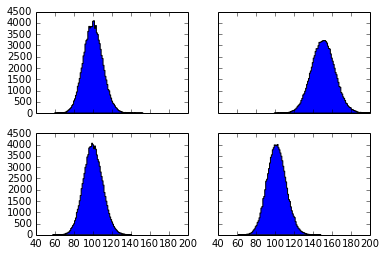

In [190]:
plt.clf()
fig, ax = plt.subplots(2,2, sharey = True, sharex = True)
for i,t in enumerate(toys):
    ax[i/2,i%2].hist(t, bins = sorted(list(set(t))), histtype ='stepfilled')

In [191]:
def lambda0(muhat,n,b,s):
    return 2*(-muhat*s + n*np.log(1+(muhat*s)/b))

def q0_twoBin_DGSS(n1,n2,b1,b2,s1,s2):
    muhat = muhatFunc(n1,n2,b1,b2,s1,s2)
    q1 = lambda0(muhat,n1,b1,s1)
    q2 = lambda0(muhat,n2,b2,s2)
    return q1+q2

In [192]:
def get_roc_plot(sb_n1,sb_n2,b_n1,b_n2,b1,b2,s1,s2):
    sb_q0, b_q0 = [q0_twoBin_DGSS(n1,n2,b1,b2,s1,s2) for n1,n2 in [(sb_n1,sb_n2), (b_n1,b_n2)]]

    sb_histo,b,_ = plt.hist(sb_q0, bins = np.linspace(0,100,100))
    b_histo,b,_ = plt.hist(b_q0, bins = b)

def get_roc(sb_n1,sb_n2,b_n1,b_n2,b1,b2,s1,s2):
    sb_q0, b_q0 = [q0_twoBin_DGSS(n1,n2,b1,b2,s1,s2) for n1,n2 in [(sb_n1,sb_n2), (b_n1,b_n2)]]

    sb_histo,b = np.histogram(sb_q0, bins = 1000)
    b_histo,b = np.histogram(b_q0, bins = b)

    integral_b = 1-np.cumsum(b_histo)/np.sum(np.float_(b_histo))
    integral_sb = 1-np.cumsum(sb_histo)/np.sum(np.float_(sb_histo))
    return integral_b,integral_sb

In [193]:
run1_nexpts = 10000
run1_toys = b_n1_run1, sb_n1_run1, b_n2_run1, sb_n2_run1 = [np.random.poisson(nu,nexpts) for nu in nus]




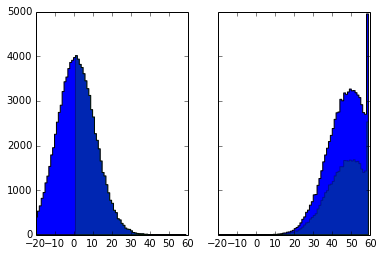

In [195]:
s1_run1 = sb_n1_run1-b1
s2_run1 = sb_n2_run1-b2
run_1_s = np.vstack((s1_run1,s2_run1)).T

s1gt0 = run_1_s[run_1_s[:,0]>0]
s2gt0 = run_1_s[run_1_s[:,1]>0]

bothgt0 = s1gt0[s1gt0[:,1]>0]

filtered_run1_n1 = bothgt0.T[0]
filtered_run1_n2 = bothgt0.T[1]
plt.clf()
fig, ax = plt.subplots(1,2, sharey = True)

c,b,_ = ax[1].hist(s1_run1, bins = range(-20,60), histtype = 'stepfilled')
c,b,_ = ax[1].hist(filtered_run1_n1, bins = b, alpha = 0.3, histtype = 'stepfilled')

c,b,_ = ax[0].hist(s2_run1, bins = b, histtype = 'stepfilled')
c,b,_ = ax[0].hist(filtered_run1_n2, bins = b, alpha = 0.3, histtype = 'stepfilled')

In [196]:
rocdata_run1toys = []
for i,(s1,s2) in enumerate(zip(filtered_run1_n1,filtered_run1_n2)[0:500]):
    if i%50 == 0:
        print i
    rocdata_run1toys += [get_roc(sb_n1,sb_n2,b_n1,b_n2,b1,b2,s1,s2)]
print 'done'

0
50
100
150
200
250
300
350
400
450
done


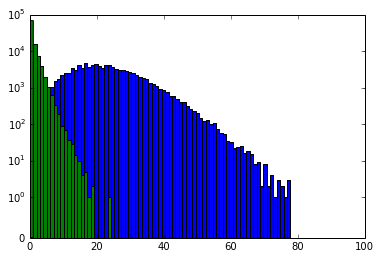

In [197]:
pylab.yscale('symlog',linthreshy=1) #works for histograms
get_roc_plot(sb_n1,sb_n2,b_n1,b_n2,b1,b2,s1truth,s2truth)
rocdata_truth = get_roc(sb_n1,sb_n2,b_n1,b_n2,b1,b2,s1truth,s2truth)

In [198]:
def rocfunc(rocdata):
    a = zip(rocdata[0],rocdata[1])
    sorted_a = sorted(a,key = lambda x:x[0])
    back = zip(*sorted_a)
    def roc(x):
        return np.interp(x,back[0],back[1])
    return roc
    

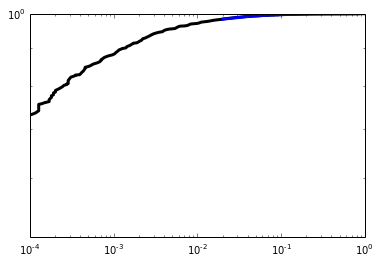

In [208]:
x = np.linspace(0,1)
y = rocfunc(rocdata_truth)(x)
plt.ylim(5e-1,1)
plt.xlim(1e-4,1)
plt.loglog()
plt.plot(*rocdata_truth, lw = 3, color = 'black')
plt.plot(x,y, lw = 3, color = 'blue', alpha = 1)

In [241]:
rocfuncs = [rocfunc(rocdata) for rocdata in rocdata_run1toys]
rocslices = [(x,[roc(x) for roc in rocfuncs]) for x in np.logspace(-5,0,1000)]

means = [(x,np.mean(slic)) for x,slic in rocslices]

400


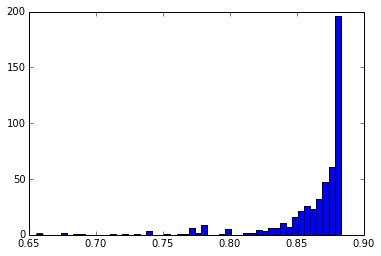

In [242]:
#take a vertical slice on the 0.05 point

index = next(i for i,(x,l) in enumerate(rocslices) if x>0.001)
print index
plt.clf()
h = plt.hist(rocslices[index][1], bins = 50)
means[index+3]

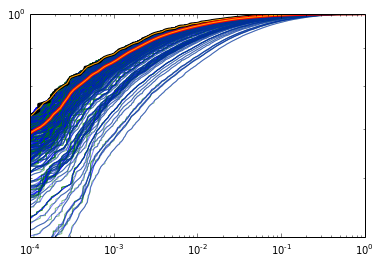

In [243]:
plt.clf()
plt.figure()
plt.loglog()
plt.ylim(5e-1,1)
plt.xlim(1e-4,1)

for rocdata in rocdata_run1toys:
    plt.plot(*rocdata, lw = 1, alpha = 0.5, color = 'green')
    x = np.logspace(-4,0,100)
    y = rocfunc(rocdata)(x)
    plt.plot(x,y, lw = 1, alpha = 0.5, color = 'blue')


plt.plot(*rocdata_truth, lw = 3, color = 'black')
plt.plot(*zip(*[(x,rocfunc(rocdata_truth)(x)) for x in np.logspace(-4,0,100)]), lw = 1, color = 'orange')

plt.plot(*zip(*means), lw = 3, color = 'red')
plt.plot(*zip(*[(x,rocfunc(zip(*means))(x)) for x in np.logspace(-4,0,100)]), lw = 1, color = 'orange')

In [244]:
rocfunc(rocdata_truth)(0.001),rocfunc(zip(*means))(0.001)